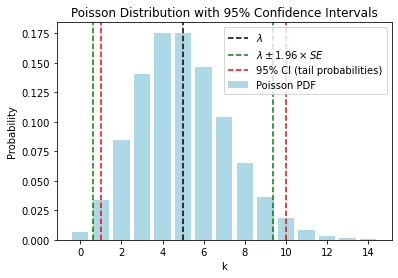

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

lambda_value = 5

# Generate values for k and their corresponding probabilities
k = np.arange(0, 3*lambda_value)
probabilities = poisson.pmf(k, lambda_value)

# Calculate the confidence intervals using tail probabilities
lower_bound = poisson.ppf(0.025, lambda_value)
upper_bound = poisson.ppf(0.975, lambda_value)

# Plot the Poisson PDF
plt.bar(k, probabilities, color='lightblue', label='Poisson PDF')

# Plot lambda
plt.axvline(lambda_value, color='black', linestyle='--', label=r'$\lambda$')

# Highlight the 95% confidence intervals using lambda and normal approximation
plt.axvline(lambda_value - 1.96 * np.sqrt(lambda_value), color='green', linestyle='--', label=r'$\lambda \pm 1.96 \times SE$')
plt.axvline(lambda_value + 1.96 * np.sqrt(lambda_value), color='green', linestyle='--')

# Highlight the 95% confidence intervals using tail probabilities
plt.axvline(lower_bound, color='red', linestyle='--', label='95% CI (tail probabilities)')
plt.axvline(upper_bound, color='red', linestyle='--')

plt.xlabel('k')
plt.ylabel('Probability')
plt.title('Poisson Distribution with 95% Confidence Intervals')
plt.legend()

plt.show()


## Neyman's construction

- Set the true mean ($\mu$) and known standard deviation ($\sigma$).
- Draw several samples from this distribution.
- Calculate the 95% confidence interval for each sample.
- Plot each confidence interval. If the interval contains the true mean, we'll color it green; otherwise, it will be red.

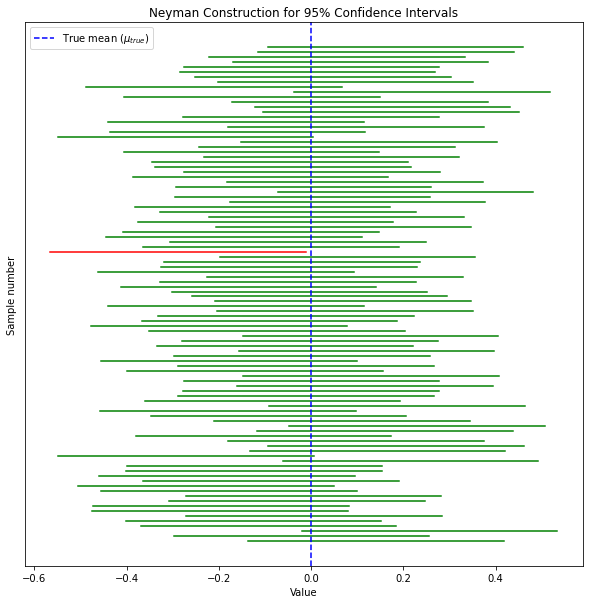

In [3]:
# Setting random seed for reproducibility
np.random.seed(0)

# Parameters
mu_true = 0       # True mean
sigma = 1         # Known standard deviation
n = 50            # Sample size
num_samples = 100 # Number of samples/confidence intervals

# Plotting
plt.figure(figsize=(10, 10))

# For each sample, calculate and plot confidence interval
for i in range(num_samples):
    sample = np.random.normal(mu_true, sigma, n)
    sample_mean = np.mean(sample)
    # Calculate the margin of error
    moe = 1.96 * (sigma / np.sqrt(n))
    lower, upper = sample_mean - moe, sample_mean + moe
    
    # Check if true mean is within the confidence interval
    if lower <= mu_true <= upper:
        plt.plot([lower, upper], [i, i], color='green')
    else:
        plt.plot([lower, upper], [i, i], color='red')

# Plotting the true mean
plt.axvline(mu_true, color='blue', linestyle='--', label='True mean ($\mu_{true}$)')
plt.yticks([])
plt.title('Neyman Construction for 95% Confidence Intervals')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Sample number')
plt.show()


## Bootstrap confidence interval for the Poisson distribution

- Generate 30 samples from a Poisson distribution with  $\lambda=5$.
- Generate 1000 bootstrap samples: A bootstrap sample is obtained by drawing 30 samples from the original set with replacement.
- Evaluate the mean of each bootstrap sample.
- Plot the bootstrap sample means as a histogram.

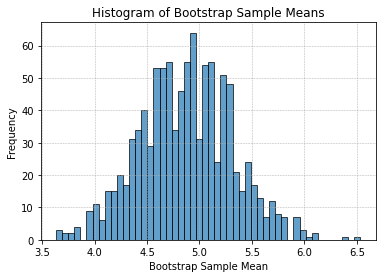

In [6]:
# Parameters
lambda_ = 5
original_sample_size = 30
num_bootstrap_samples = 1000

# 1. Generate 30 samples from a Poisson distribution
original_samples = np.random.poisson(lambda_, original_sample_size)

# 2. Generate 1000 bootstrap samples and 3. evaluate their means
bootstrap_means = []
for _ in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(original_samples, size=original_sample_size, replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

# 4. Plot the bootstrap sample means as a histogram
plt.hist(bootstrap_means, bins=50, edgecolor="k", alpha=0.7)
plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Frequency')
plt.title('Histogram of Bootstrap Sample Means')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Now we visulalize the Bootstrap cumulative distribution function

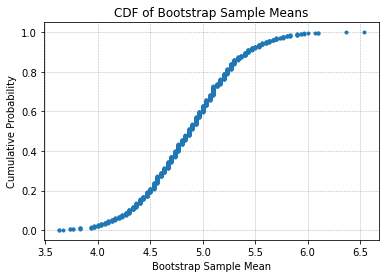

In [7]:
# Plot the CDF for bootstrap sample means
sorted_means = np.sort(bootstrap_means)
cumulative_probs = np.arange(1, num_bootstrap_samples + 1) / num_bootstrap_samples

plt.plot(sorted_means, cumulative_probs, marker='.', linestyle='none')
plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Bootstrap Sample Means')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

We can now evaluate the bootstrap 95% confidence intervals

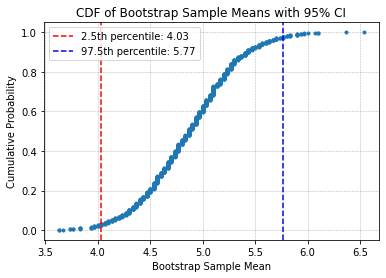

In [8]:
# Compute the 2.5th and 97.5th percentiles of the bootstrap sample means
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

# Plot the CDF for bootstrap sample means
sorted_means = np.sort(bootstrap_means)
cumulative_probs = np.arange(1, num_bootstrap_samples + 1) / num_bootstrap_samples

plt.plot(sorted_means, cumulative_probs, marker='.', linestyle='none')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'2.5th percentile: {lower_bound:.2f}')
plt.axvline(upper_bound, color='blue', linestyle='--', label=f'97.5th percentile: {upper_bound:.2f}')

plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Bootstrap Sample Means with 95% CI')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### Bias adjusted confidence intervlas

To estimate a bias-corrected (BC) confidence interval using bootstrap samples, we can follow these general steps:

 - Compute the statistic of interest (in our case, the mean) from the original sample.

**Bootstrap Bias Estimation**:
   - Compute the same statistic for each bootstrap sample.
   - Calculate the proportion of bootstrap sample statistics that are less than the original sample statistic. This proportion (or its complement) provides an estimate of bias. It's often referred to as `z_0`.

**Calculate Adjusted Percentiles for Confidence Interval**:
   - Use `z_0` to adjust the percentiles for calculating the confidence interval.
   
Given the previous Poisson distribution example, let's compute the bias-corrected 95% confidence interval:



In [11]:
from scipy.stats import norm

#original mean
sample_mean = np.mean(bootstrap_sample)

# Evaluate the bias-corrected (BC) 95% confidence interval for the mean
# Compute the bias
bias = sample_mean - np.mean(bootstrap_means)

# Calculate z0
z0 = norm.ppf(sum(mean < sample_mean for mean in bootstrap_means) / 1000)

# Calculate the adjusted percentiles
alpha_lower = norm.cdf(2*z0 + norm.ppf(0.025))
alpha_upper = norm.cdf(2*z0 + norm.ppf(0.975))

# Find the confidence intervals
bootstrap_means_sorted = sorted(bootstrap_means)
lower_bound = bootstrap_means_sorted[int(alpha_lower * 1000)]
upper_bound = bootstrap_means_sorted[int(alpha_upper * 1000)]

print(f"Original Sample Mean: {sample_mean}")
print(f"Bias: {bias}")
print(f"Bias-Corrected 95% Confidence Interval: ({lower_bound}, {upper_bound})")



Original Sample Mean: 5.133333333333334
Bias: 0.26473333333333393
Bias-Corrected 95% Confidence Interval: (4.533333333333333, 6.533333333333333)


The BCa method

In [13]:


# Compute z0
z_0 = norm.ppf(sum(mean < sample_mean for mean in bootstrap_means) / num_bootstrap_samples)

# Compute acceleration (a) - using the jackknife method
jackknife_means = [np.mean(np.delete(original_samples, i)) for i in range(original_sample_size)]
a = np.sum((np.mean(original_samples) - jackknife_means)**3) / (6 * (np.sum((np.mean(original_samples) - jackknife_means)**2)**1.5))

# Compute the bias-corrected and accelerated percentiles
alpha = 0.05
lower_bound = np.percentile(bootstrap_means, 100*norm.cdf(z_0 + (z_0 + norm.ppf(alpha/2)) / (1 - a*(z_0 + norm.ppf(alpha/2)))))
upper_bound = np.percentile(bootstrap_means, 100*norm.cdf(z_0 + (z_0 + norm.ppf(1 - alpha/2)) / (1 - a*(z_0 + norm.ppf(1 - alpha/2)))))

print(f"BCa 95% Confidence Interval: ({lower_bound:.3f}, {upper_bound:.3f})")


BCa 95% Confidence Interval: (4.533, 6.449)


## Bootstrap-t intervals

To estimate the confidence interval for the difference in means of samples \( x \) and \( y \) using the bootstrap-t method, follow these steps:

1. Calculate the observed difference in means: $ \bar{d} = \bar{x} - \bar{y} $.
2. Pool the two samples and center them around their combined mean.
3. Resample pairs of samples from the pooled, centered data, then un-center one of the samples using the original sample mean of \( x \) and the other using the original sample mean of \( y \).
4. For each bootstrap resampling, compute the difference in means.
5. Compute the standard error of the bootstrapped differences.
6. For each bootstrap resampling, compute the t-statistic using the formula: $ t^* = \frac{\text{bootstrapped difference} - \bar{d}}{\text{standard error of bootstrapped differences}} $.
7. Use the percentiles of these bootstrapped t-statistics to compute the bootstrap-t confidence interval.



In [14]:
import numpy as np

np.random.seed(42)  # For reproducibility

# Given samples x and y:
x = np.random.normal(10, 2, 100)  # for demonstration
y = np.random.normal(12, 2, 100)  # for demonstration

# 1. Calculate observed difference in means:
obs_diff = np.mean(x) - np.mean(y)

# 2. Pool the two samples and center them:
pooled = np.concatenate([x, y])
pooled_centered = pooled - np.mean(pooled)
x_centered = x - np.mean(x)
y_centered = y - np.mean(y)

# 3. Bootstrap resampling:
bootstrap_diffs = []
for _ in range(1000):
    bootstrap_x = np.random.choice(pooled_centered, len(x), replace=True) + np.mean(x)
    bootstrap_y = np.random.choice(pooled_centered, len(y), replace=True) + np.mean(y)
    bootstrap_diffs.append(np.mean(bootstrap_x) - np.mean(bootstrap_y))

# 4 & 5. Standard error of bootstrapped differences:
se = np.std(bootstrap_diffs)

# 6. Compute t-statistics:
t_star = (bootstrap_diffs - obs_diff) / se

# 7. Compute bootstrap-t confidence interval:
alpha = 0.05
lower_percentile = np.percentile(t_star, alpha/2 * 100)
upper_percentile = np.percentile(t_star, (1-alpha/2) * 100)

lower_bound = obs_diff - upper_percentile * se
upper_bound = obs_diff - lower_percentile * se

print(f"Bootstrap-t 95% Confidence Interval: ({lower_bound}, {upper_bound})")


Bootstrap-t 95% Confidence Interval: (-2.8532623124367538, -1.6418465585717326)


We illustrate this in a figure

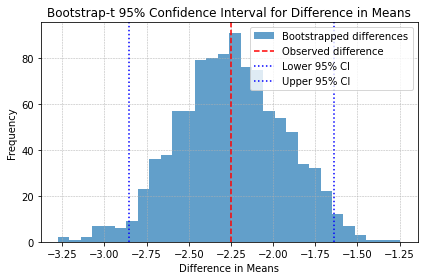

In [15]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility

# Given samples x and y:
x = np.random.normal(10, 2, 100)  # for demonstration
y = np.random.normal(12, 2, 100)  # for demonstration

# 1. Calculate observed difference in means:
obs_diff = np.mean(x) - np.mean(y)

# 2. Pool the two samples and center them:
pooled = np.concatenate([x, y])
pooled_centered = pooled - np.mean(pooled)
x_centered = x - np.mean(x)
y_centered = y - np.mean(y)

# 3. Bootstrap resampling:
bootstrap_diffs = []
for _ in range(1000):
    bootstrap_x = np.random.choice(pooled_centered, len(x), replace=True) + np.mean(x)
    bootstrap_y = np.random.choice(pooled_centered, len(y), replace=True) + np.mean(y)
    bootstrap_diffs.append(np.mean(bootstrap_x) - np.mean(bootstrap_y))

# 4 & 5. Standard error of bootstrapped differences:
se = np.std(bootstrap_diffs)

# 6. Compute t-statistics:
t_star = (bootstrap_diffs - obs_diff) / se

# 7. Compute bootstrap-t confidence interval:
alpha = 0.05
lower_percentile = np.percentile(t_star, alpha/2 * 100)
upper_percentile = np.percentile(t_star, (1-alpha/2) * 100)

lower_bound = obs_diff - upper_percentile * se
upper_bound = obs_diff - lower_percentile * se

# Plot
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, label="Bootstrapped differences")
plt.axvline(obs_diff, color="red", linestyle="--", label="Observed difference")
plt.axvline(lower_bound, color="blue", linestyle=":", label="Lower 95% CI")
plt.axvline(upper_bound, color="blue", linestyle=":", label="Upper 95% CI")
plt.title("Bootstrap-t 95% Confidence Interval for Difference in Means")
plt.xlabel("Difference in Means")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### The t-distribution

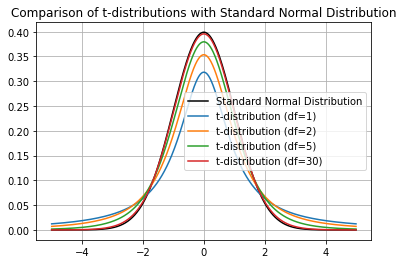

In [16]:
from scipy.stats import t

x = np.linspace(-5, 5, 1000)

# Plot standard normal distribution
plt.plot(x, norm.pdf(x, 0, 1), label='Standard Normal Distribution', color='black')

# Plot t-distributions for different degrees of freedom
for df in [1, 2, 5, 30]:
    plt.plot(x, t.pdf(x, df), label=f't-distribution (df={df})')

plt.title("Comparison of t-distributions with Standard Normal Distribution")
plt.legend()
plt.grid(True)
plt.show()
